# D84-1
* **比較不同的regularization的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization等**

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/rex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l2


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4]
Dropout_EXP = [0.15, 0.2]

In [10]:
results = {}

for regulizer_ratio in L2_EXP:
    for drop_ratio in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        print("Experiment with Dropout = %.6f" % (drop_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, drp_ratio = drop_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l2-%s-%s" % (str(regulizer_ratio),str(drop_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Experiment with Dropout = 0.150000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
drop

50000/50000 [==============================] - 7s 138us/step - loss: 1.4191 - acc: 0.5529 - val_loss: 1.6142 - val_acc: 0.4797
Epoch 47/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4301 - acc: 0.5490 - val_loss: 1.6557 - val_acc: 0.4623
Epoch 48/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4283 - acc: 0.5496 - val_loss: 1.6198 - val_acc: 0.4873
Epoch 49/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.4181 - acc: 0.5498 - val_loss: 1.7020 - val_acc: 0.4467
Epoch 50/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4136 - acc: 0.5517 - val_loss: 1.6636 - val_acc: 0.4787
Experiment with Regulizer = 0.010000
Experiment with Dropout = 0.200000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_______________________________________________

50000/50000 [==============================] - 7s 133us/step - loss: 1.4930 - acc: 0.5255 - val_loss: 1.6809 - val_acc: 0.4606
Epoch 42/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.4851 - acc: 0.5270 - val_loss: 1.5747 - val_acc: 0.4938
Epoch 43/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.4764 - acc: 0.5282 - val_loss: 1.7432 - val_acc: 0.4185
Epoch 44/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.4747 - acc: 0.5274 - val_loss: 1.5797 - val_acc: 0.4848
Epoch 45/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.4805 - acc: 0.5247 - val_loss: 1.8039 - val_acc: 0.4266
Epoch 46/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.4822 - acc: 0.5260 - val_loss: 1.6307 - val_acc: 0.4763
Epoch 47/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.4810 - acc: 0.5250 - val_loss: 1.5869 - val_acc: 0.4839
Epoch 48/50
50000/50000 [==========

50000/50000 [==============================] - 7s 130us/step - loss: 1.3082 - acc: 0.5811 - val_loss: 1.4780 - val_acc: 0.5207
Epoch 37/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.2999 - acc: 0.5828 - val_loss: 1.4937 - val_acc: 0.5134
Epoch 38/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.2919 - acc: 0.5855 - val_loss: 1.5032 - val_acc: 0.5184
Epoch 39/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.2870 - acc: 0.5896 - val_loss: 1.5246 - val_acc: 0.5070
Epoch 40/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.2771 - acc: 0.5920 - val_loss: 1.4857 - val_acc: 0.5250
Epoch 41/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.2792 - acc: 0.5904 - val_loss: 1.5108 - val_acc: 0.5101
Epoch 42/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.2725 - acc: 0.5920 - val_loss: 1.5239 - val_acc: 0.5096
Epoch 43/50
50000/50000 [==============

50000/50000 [==============================] - 6s 128us/step - loss: 1.4076 - acc: 0.5431 - val_loss: 1.4858 - val_acc: 0.5187
Epoch 32/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4044 - acc: 0.5446 - val_loss: 1.4790 - val_acc: 0.5136
Epoch 33/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.4000 - acc: 0.5482 - val_loss: 1.4861 - val_acc: 0.5160
Epoch 34/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.3949 - acc: 0.5481 - val_loss: 1.5376 - val_acc: 0.5025
Epoch 35/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.3924 - acc: 0.5485 - val_loss: 1.4718 - val_acc: 0.5213
Epoch 36/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.3830 - acc: 0.5528 - val_loss: 1.5001 - val_acc: 0.5194
Epoch 37/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.3825 - acc: 0.5514 - val_loss: 1.4557 - val_acc: 0.5294
Epoch 38/50
50000/50000 [==============

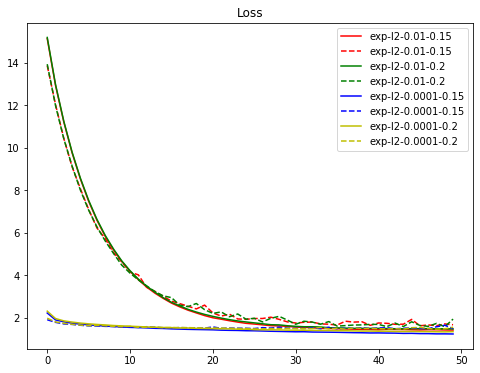

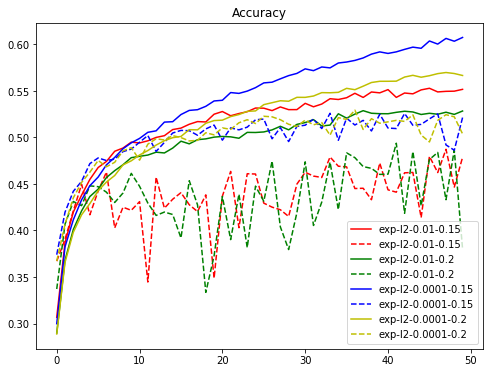

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()